# Exploration of data

## Goals

The goals of this notebook are the following:
- Identify the proportion of positive and negative cases in the data and use this to decide if additional steps are required before classification
- Identify the type of each feature
- Identify what cleaning the data set requires and act accordingly
- Separate the dataset into training data and testing data
- Explore additional features
- Export the dataset, along with any added features

## Import libraries and data

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pickle as pkl

In [3]:
#read csv into df
start_df = pd.read_csv('heart.csv')

#check details of df
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Data has no null values which means that we do not need to consider what to do with features with missing values.

In [4]:
#check details of target column to ensure just 1 and 0s
start_df.target.unique()

array([1, 0], dtype=int64)

Target is binary class.

## Initial analysis of the target / features

### Target analysis

In [5]:
start_df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [6]:
start_df['target'].mean()

0.5445544554455446

Our data is a fairly even mix of cases where heart disease is and is not present.
Just under 55% of cases have heart disease.
This is sufficiently close to 50% that there is no need to make any changes to the data however we should be conscious of the slight inbalance when training algorithms on the data and we should explore any inbalance in precision/recall.

### Separating discrete and continuous features

In [7]:
# identify the number of unique values of each feature
# this will help decide whether the feature needs to be treated as categorical or numerical
start_df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

Using these values, and the description of the features (found on the Kaggle page) we can separate the variables into categorical and numerical variables as such:
- num_features: age, trestbps, chol, thalach, oldpeak, thal
- cat_features: sex, cp, fbs, restecg, exang, slope, ca

In [8]:
num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'thal']
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca']

We can then reassign the types in our dataframe to match these expectations.

In [9]:
dtypes = {}
for feature in cat_features:
    dtypes[feature] = 'category'
    
start_df = start_df.astype(dtypes)

## Split data

We will separate our data using a stratified 80-20 split.

In [10]:
#create list of features
features = list(start_df.columns)
features.remove('target')

#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(start_df[features], start_df['target'], test_size = 0.2, random_state = 42, stratify = start_df['target'])

##  Deeper analysis of the target / features

### Visualising continuous features

#### Distribution

In [50]:
# set up seaborn settings
sns.set(style='ticks', palette='Set2')

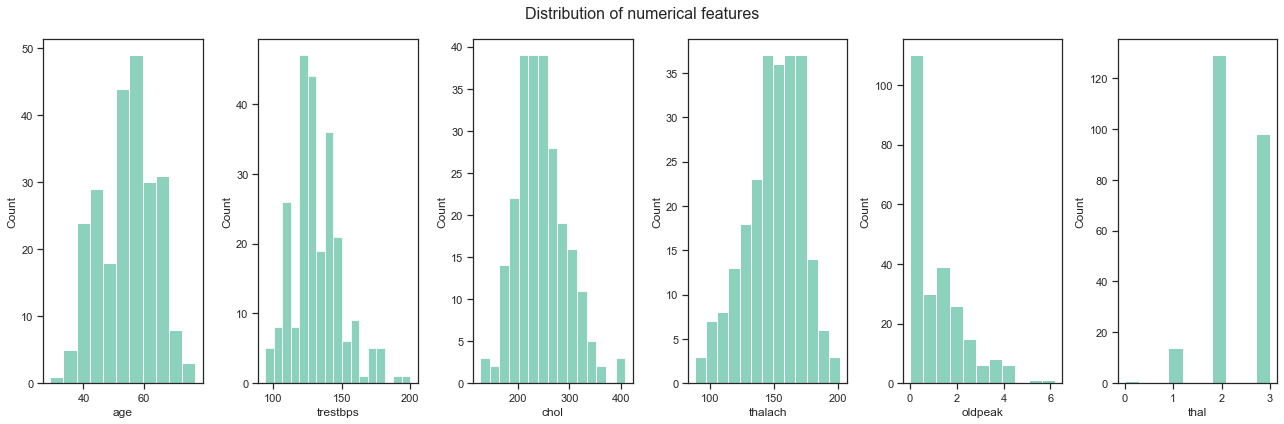

In [11]:
fig, ax = plt.subplots(ncols = 6, figsize = (18, 6))
for i, feature in enumerate(num_features):
    sns.histplot(x = feature, data = X_train, ax = ax[i])
fig.suptitle('Distribution of numerical features', fontsize=16)
fig.tight_layout()

In most cases these looks close enough to a normal distribution that they should be usable as they are.
It may be worth experimenting on transformations of some of the features later to see if this improves performance.

Oldpeak is clearly not anywhere close to normally distributed.
We will explore transforming this.

Thal has too few values for any discussion of it's approximation to a nomral distribution.
We will have to treat this feature differently when it comes to transformations.

##### Transforming oldpeak

Firstly check what the minimum values of oldpeak are, in cases there are any zeros.

In [14]:
X_train['oldpeak'].describe()

count    242.000000
mean       1.071901
std        1.206258
min        0.000000
25%        0.000000
50%        0.800000
75%        1.800000
max        6.200000
Name: oldpeak, dtype: float64

Ok so a logarithmic transformation will not work as there are 0s present.

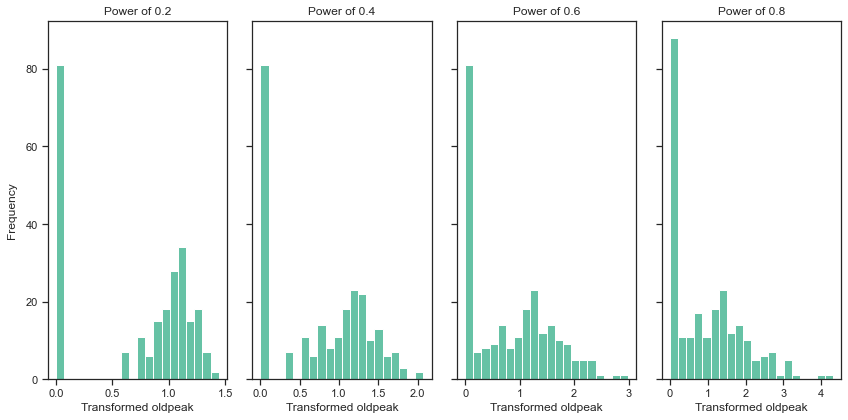

In [33]:
fig, ax = plt.subplots(ncols = 4, figsize = (12, 6), sharey = True)
for i in range(1, 5):
    power = i*0.2
    newoldpeak = X_train['oldpeak']**power
    ax[i-1].hist(newoldpeak, bins = 20)
    
    # using round as was previously presenting 0.6 as 0.60000001
    ax[i-1].set_title('Power of ' + str(round(power, 1))) 
    ax[i -1].set_xlabel('Transformed oldpeak')

fig.supylabel('Frequency', fontsize = 12)
fig.tight_layout()

Although it is possible to transform all non-zero values to an approximately normal distribution, it will always be impossible to transform the entire set into anything resembling a normal distribution.
Thus we will leave oldpeak as it is for the moment.

###### Question: Do I need to transform this variable? If so, how should it be transformed?

#### Visualisation distribution within classes

As there are so few distint values for thal, we will separate this from the remaining numerical features for the rest of this analysis.

In [38]:
num_features.remove('thal')

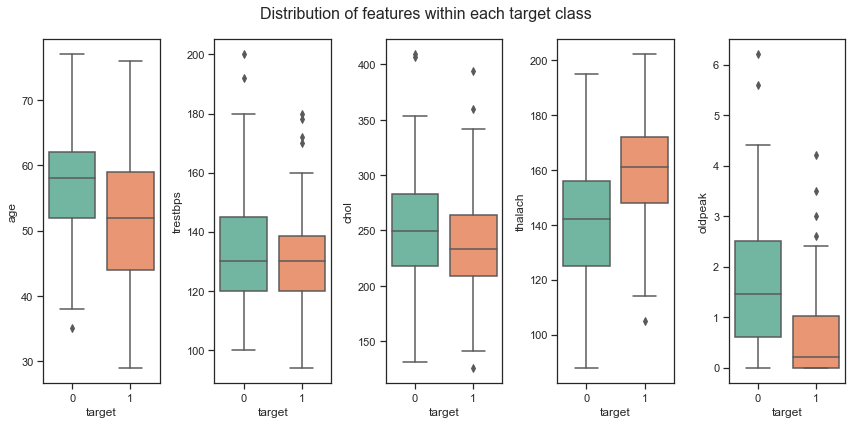

In [39]:
fig, ax = plt.subplots(ncols = 5, figsize = (12, 6))
for i, feature in enumerate(num_features):
    sns.boxplot(y = feature, x = 'target', data = pd.concat([X_train, y_train], axis = 1), ax = ax[i])

fig.suptitle('Distribution of features within each target class', fontsize = 16)    
fig.tight_layout()

There are a couple of cases of high outliers however I do not think that this is worth adjusting for.
Judging by eye, thalach or oldpeak look to be the most useful single predictors based on these visualisations as there is the largest separation between the majority of cases within two classes.

### Analysing discrete features

In [19]:
for feature in disc_features:
    # identify different values of each feature and their frequencies
    print(pd.concat([X_train, y_train], axis = 1).groupby(feature, as_index = True)['target'].mean(), '\n')

sex
0    0.727273
1    0.460606
Name: target, dtype: float64 

cp
0    0.260870
1    0.804878
2    0.816901
3    0.733333
Name: target, dtype: float64 

fbs
0    0.552885
1    0.500000
Name: target, dtype: float64 

restecg
0    0.456140
1    0.637097
2    0.250000
Name: target, dtype: float64 

exang
0    0.706250
1    0.231707
Name: target, dtype: float64 

slope
0    0.352941
1    0.333333
2    0.769231
Name: target, dtype: float64 

ca
0    0.731884
1    0.345455
2    0.185185
3    0.176471
4    0.800000
Name: target, dtype: float64 

thal
0    1.000000
1    0.285714
2    0.806202
3    0.234694
Name: target, dtype: float64 



Ok so there are some good indicators here:
- sex clearly shows that cases are more prevalent within one sex than the other (this means that we will have to be careful to check on accuracy in reporting between different sexes)
- exang has a similarly large difference in prevalence between the two values
- cp (predictably) looks to be a powerful indicator


- fbs does not look particularly useful on its own

## Exploring additional features

### Quotients

Let's begin by exploring the ratios between the continuous variables and see if anything good comes out of there.

In [40]:
num_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

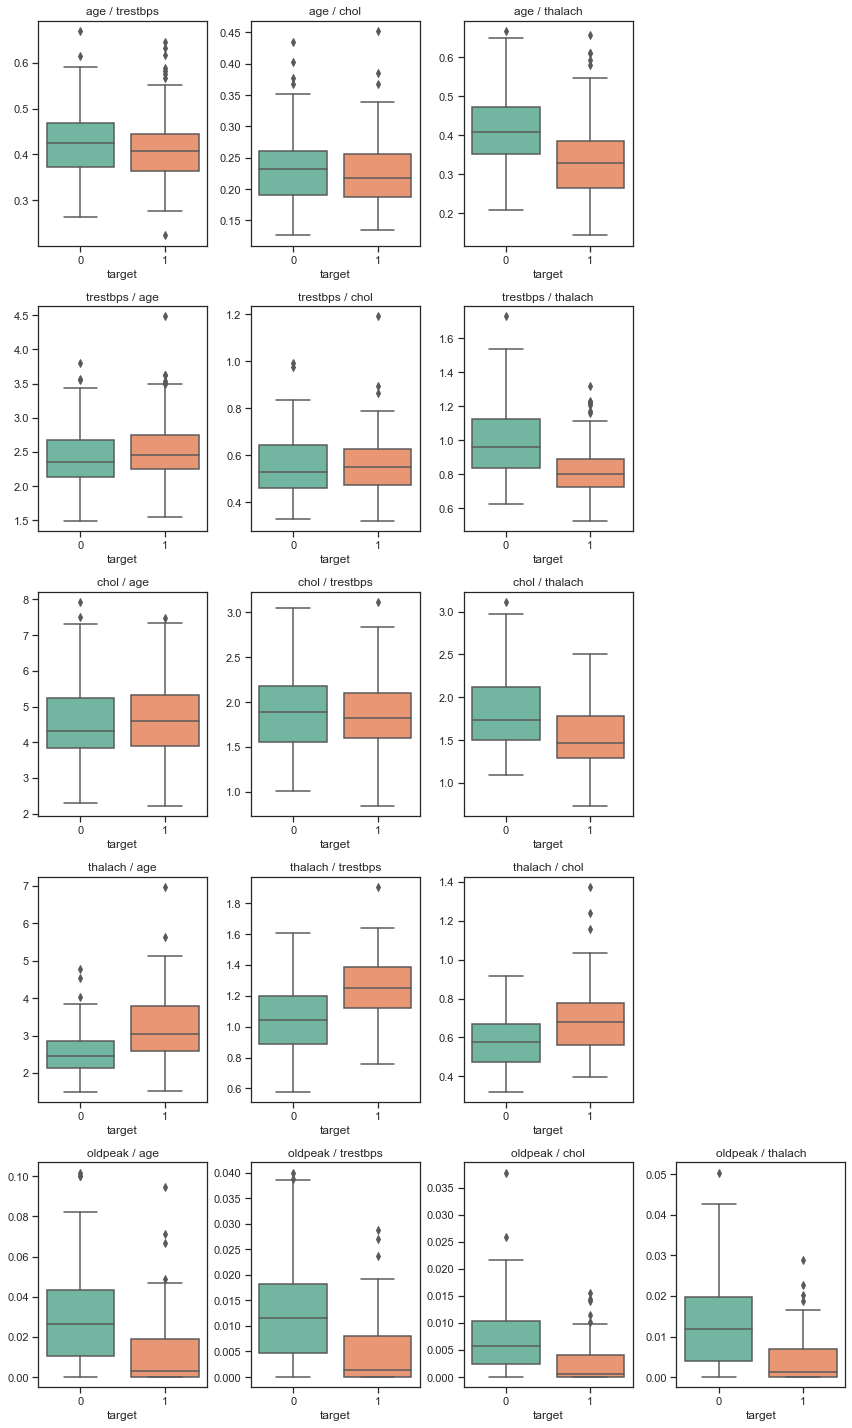

In [42]:
fig, ax = plt.subplots(nrows = 5, ncols = 4, figsize = (12, 20))

for i, feature1 in enumerate(num_features):
    num_features_copy = num_features.copy()
    
    # we do not want to present the case where we divide the feature by itself
    num_features_copy.remove(feature1)
    
    # we do not want to include cases where we divide by oldpeak as this can be 0
    if 'oldpeak' in num_features_copy:
        num_features_copy.remove('oldpeak')
        # hide the axes that would have been used
        ax[i][3].set_visible(False)
    
    # plot the graphs for each pair of divisors
    for j, feature2 in enumerate(num_features_copy):
        name = feature1 + ' / ' + feature2
        field = X_train[feature1] / X_train[feature2]
        sns.boxplot(y = field, x = 'target', data = pd.concat([field, y_train], axis = 1), ax = ax[i][j])
        ax[i][j].set_title(name)
        
# adjust presentation
fig.tight_layout()

Were I to choose between which features here are worth keeping I would probably keep:
 - thalach / age
 - thalach / trestbps
 

However later on we will look into the effects of using different subsets of these features and choose accordingly which to keep and which to remove.

### Products

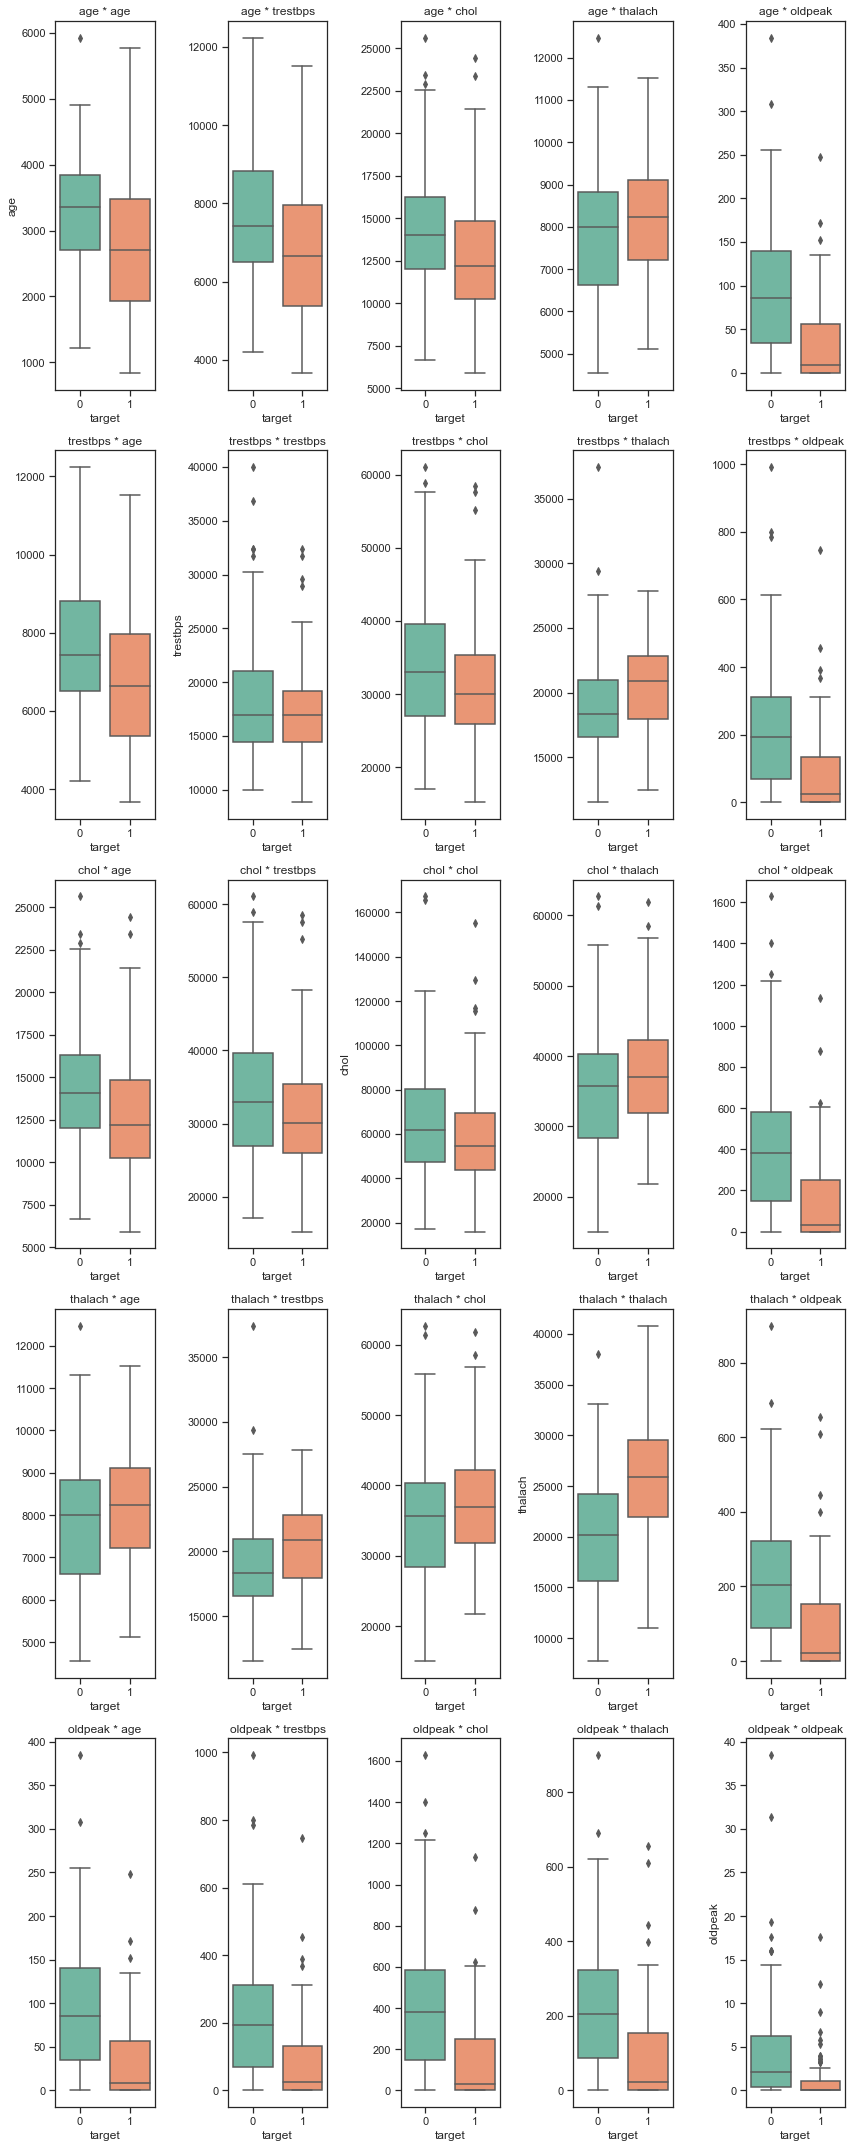

In [43]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (12, 30))
for i, feature1 in enumerate(num_features):
    for j, feature2 in enumerate(num_features):
        name = feature1 + ' * ' + feature2
        field = X_train[feature1] * X_train[feature2]
        sns.boxplot(y = field, x = 'target', data = pd.concat([y_train, field], axis = 1), ax = ax[i][j])
        ax[i][j].set_title(name)
fig.tight_layout()

Again though, we will include these values and evaluate their effectiveness as features later when we begin developing algorithms.

## Feature Addition

Let's add these features back into the original data in order to use them in our algorithms.
Were we to actually deploy an algorithm we would need to have the feature addition as part of our pipeline, however, given that we will not be deploying anything, it seems like a waste of processing power to generate these new features repeatedly rather than simply doing it once now.

In [46]:
divisions = []
for feature1 in num_features:
        
    num_features_copy = num_features.copy()
    # we do not want to present the case where we divide the feature by itself
    num_features_copy.remove(feature1)

    if feature1 != 'oldpeak':
        num_features_copy.remove('oldpeak')

    # add the quotient to the df
    for feature2 in num_features_copy:
        name = feature1 + ' / ' + feature2
        start_df[name] =  start_df[feature1] / start_df[feature2]
        
        divisions.append(name)

In [48]:
products = []
remaining_features = num_features.copy()
for feature1 in num_features:
    for feature2 in remaining_features:
        
        name = feature1 + ' * ' + feature2
        start_df[name] =  start_df[feature1] *  start_df[feature2]
        products.append(name)
    remaining_features.remove(feature1)

## Export the data and valuable lists

In [57]:
# export the df
start_df.to_pickle('extended_heart_disease.pkl')

# set up a dictionary of useful lists
useful_lists = {
    'num_features' : num_features
    , 'cat_features' : cat_features
    , 'products' : products
    , 'divisions' : divisions
}

#export dict
with open("useful_lists.pkl", "wb") as f:
     pkl.dump(useful_lists, f)